In [1]:
import torch


import numpy as np
import os
import matplotlib.pyplot as plt

import sys
sys.path.append('../code')

In [2]:
#import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
import importlib

import modular.initial_guesser as IG
import modular.forward_model as FM
import modular.optimize_volume as OV

importlib.reload(FM)
importlib.reload(OV)
importlib.reload(IG)

<module 'modular.initial_guesser' from 'c:\\Users\\Fredrik\\Documents\\GitHub\\TomoNnRot\\tests\\../code\\modular\\initial_guesser.py'>

In [4]:
### Set the device ###
DEV = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = 'C:/Users/Fredrik/Desktop/RotationsData/Movies_cropped_np/'


In [5]:
files = os.listdir('../data/Movies_cropped_np')
rotation_listxy = np.load('../data/rotation_list_xy.npy')

In [6]:
print(files)

['movie11.npy', 'movie12.npy', 'movie16.npy', 'movie17.npy', 'movie6.npy', 'movie7.npy', 'movie8.npy', 'movie9.npy', 'movie_1726.npy', 'S2.npy', 'S5.npy', 'S6.npy']


In [7]:
idx = -4
projections = np.load(data_path + files[idx])

In [8]:
print(projections.shape)

(1500, 128, 128)


In [9]:
projections = projections[0:600]

In [10]:
def rotate_image(image, angle):
    from scipy.ndimage import rotate
    """
    Rotates a 2D image by a specified angle.

    Args:
        image: A 2D numpy array representing the image.
        angle: The angle (in degrees) to rotate the image by.

    Returns:
        The rotated image as a 2D numpy array.
    """
    # Perform the rotation using the scipy.ndimage.rotate function
    rotated_image = rotate(image, angle, reshape=False)

    return rotated_image

def pad_image(image, padsize):
    """
    Pads a 2D image with zeros on all sides.

    Args:
        image: A 2D numpy array representing the image.
        padsize: The number of pixels to pad the image by.

    Returns:
        The padded image as a 2D numpy array.
    """
    # Perform the padding using the np.pad function
    padded_image = np.pad(image, padsize, mode='constant', constant_values=0)

    return padded_image

def inverse_pixels(image):
    """
    Inverts the pixel values of a 2D image.

    Args:
        image: A 2D numpy array representing the image.

    Returns:
        The image with the pixel values inverted.
    """
    # Perform the inversion using the np.invert function
    inverted_image = np.invert(image)

    return inverted_image

In [11]:
projections = inverse_pixels(projections)

In [12]:
rotation_case = 1
padsize = 32

for i in range(0, projections.shape[0]):
    projections[i] = rotate_image(pad_image(projections[i], padsize=padsize), rotation_listxy[idx, rotation_case])[padsize:-padsize, padsize:-padsize]

In [13]:
print(projections.shape)

(600, 128, 128)


In [14]:
# Downsample the projections to 64x64 using pytorch
projections = torch.tensor(projections, device=DEV).float()

# Desired output size
new_height = 96
new_width = 96

# Downsample the batch of images
projections = torch.nn.functional.interpolate(projections.unsqueeze(1), size=(new_height, new_width), mode='bilinear', align_corners=False).squeeze(1)


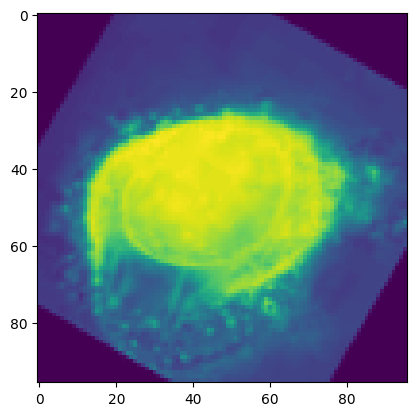

In [15]:
plt.imshow(projections[0].cpu().numpy())

In [16]:
#Inverse image


In [17]:
ig = IG.InitialGuesser(frames=projections, step_size=2, initial_axes="x")

In [18]:
ig.pipeline()

Training VAE...
Epoch 1/1000, Loss: 135.80663108825684, KL Loss: 0.00010011209099047846, Recon Loss: 135.80653190612793
Epoch 11/1000, Loss: 6.109809637069702, KL Loss: 0.06104940176010132, Recon Loss: 6.048760294914246
Epoch 21/1000, Loss: 5.088759183883667, KL Loss: 0.05580354481935501, Recon Loss: 5.032955646514893
Epoch 31/1000, Loss: 4.905622243881226, KL Loss: 0.05129817081615329, Recon Loss: 4.854324162006378
Epoch 41/1000, Loss: 4.527881860733032, KL Loss: 0.0513524217531085, Recon Loss: 4.476529479026794
Epoch 51/1000, Loss: 3.913443446159363, KL Loss: 0.052382908295840025, Recon Loss: 3.8610605001449585
Epoch 61/1000, Loss: 3.7160197496414185, KL Loss: 0.04909632308408618, Recon Loss: 3.666923463344574
Epoch 71/1000, Loss: 3.515522301197052, KL Loss: 0.04564370261505246, Recon Loss: 3.4698785543441772
Epoch 81/1000, Loss: 3.276265561580658, KL Loss: 0.04143427265807986, Recon Loss: 3.2348313331604004
Epoch 91/1000, Loss: 2.8374160528182983, KL Loss: 0.03907151520252228, Recon

c:\Users\Fredrik\Documents\GitHub\TomoNnRot\tests\../code\modular\initial_guesser.py:214: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.angle_rotations[:, 0] = torch.tensor(self.angle)


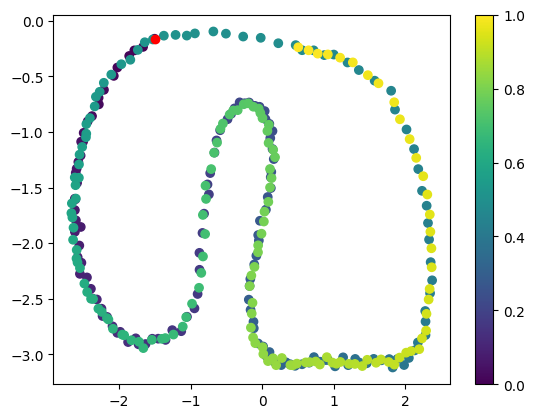

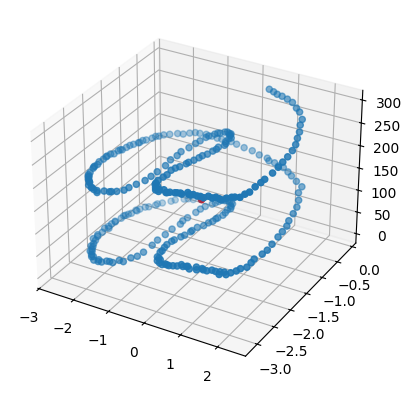

In [19]:
#Plot z
z = ig.z.detach().cpu().numpy()
plt.scatter(z[:, 0], z[:, 1], c=np.arange(z.shape[0]))
#start_point
plt.scatter(z[0, 0], z[0, 1], c='r')
plt.colorbar()
plt.show()

#3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z[:, 0], z[:, 1], np.arange(z.shape[0]))
ax.scatter(z[0, 0], z[0, 1], c='r')
plt.show()

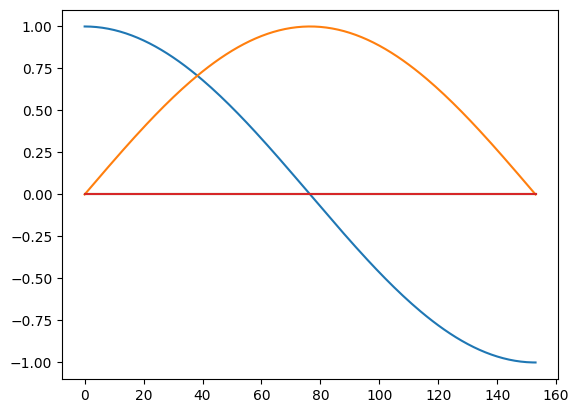

In [20]:
# Plot the quaternions
q1 = ig.quaternions.detach().cpu().numpy()
plt.plot(q1)
plt.show()

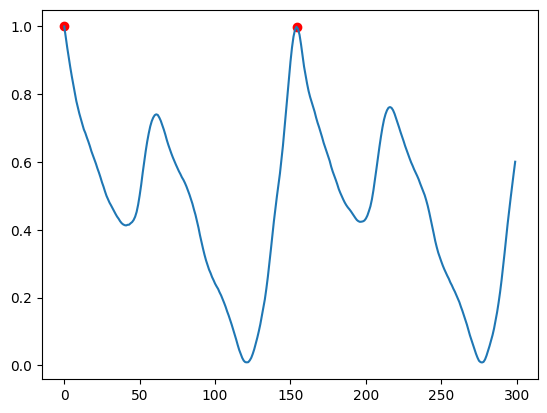

In [21]:
plt.plot(ig.res)
#Add dots where the peaks from ig.peaks
plt.scatter(ig.peaks, ig.res[ig.peaks], c='r')

In [22]:
fm = FM.ForwardModelSimple(N=projections.shape[1])
ov = OV.OptimizeVolume(forward_model=fm, quaternions_init=ig.quaternions, projections=ig.frames, initial_volume='fbp')

In [34]:
ov.fit(
    epochs=1000,
    learning_rate=8e-3,
    loss_weights=[10, 10, 0.1, 0.1, 10],
    gaussian_blur=False,
    gaussian_range=[1e-5, 2],
    volume_optim_wait=300
    )

Using Adam optimizer with learning rate 0.008
Using ReduceLROnPlateau scheduler with patience 50
Number of batches: 1
Number of epochs: 1000
Batch size: 1000
Learning rate: 0.008
Loss weights: [10, 10, 0.1, 0.1, 10]
Optimizing quaternions: True
Using Gaussian blur: False
Quaternions optimization wait: 0
Optimizing quaternions now.
Epoch 1/1000, Total loss: 0.35525, MAE loss: 0.31603, Rotational loss: 0.03849, TV loss: 0.00048, Quaternion validity loss: 0.00025, q0 constraint loss: 0.00000
Epoch 2/1000, Total loss: 0.71271, MAE loss: 0.59673, Rotational loss: 0.08923, TV loss: 0.00048, Quaternion validity loss: 0.00037, q0 constraint loss: 0.02589
Epoch 3/1000, Total loss: 0.58703, MAE loss: 0.52458, Rotational loss: 0.05965, TV loss: 0.00048, Quaternion validity loss: 0.00029, q0 constraint loss: 0.00202
Epoch 4/1000, Total loss: 0.55856, MAE loss: 0.49450, Rotational loss: 0.05807, TV loss: 0.00048, Quaternion validity loss: 0.00029, q0 constraint loss: 0.00522
Epoch 5/1000, Total los

KeyboardInterrupt: 

In [35]:
vol = ov.get_volume_np()

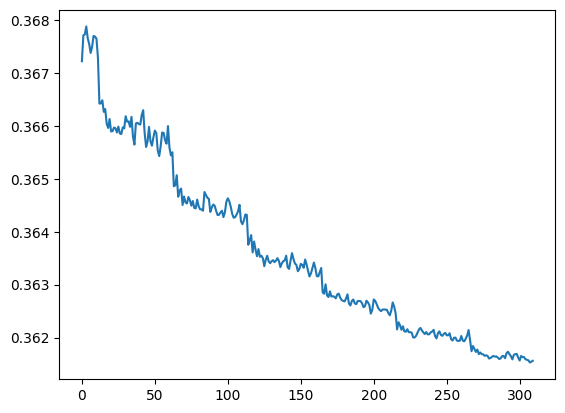

In [36]:
plt.plot(ov.loss_total[500:])

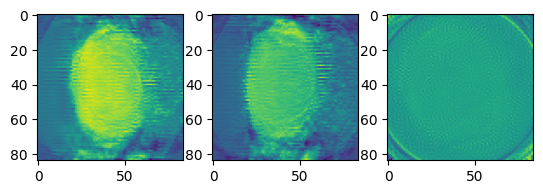

In [37]:
# a 3x1 plot of the volume summed along each axis
pad = 6
vol = vol[pad:-pad, pad:-pad, pad:-pad]
fig, axs = plt.subplots(1, 3)
axs[0].imshow(vol.sum(axis=0))
axs[1].imshow(vol.sum(axis=1))
axs[2].imshow(vol.sum(axis=2))
plt.show()

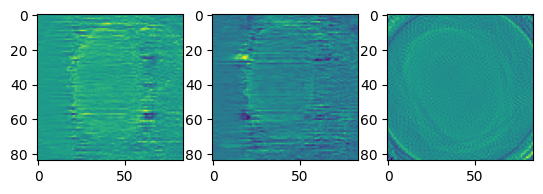

In [38]:
# Show slices in the volume
fig, axs = plt.subplots(1, 3)
axs[0].imshow(vol[32])
axs[1].imshow(vol[:, 32])
axs[2].imshow(vol[:, :, 32])

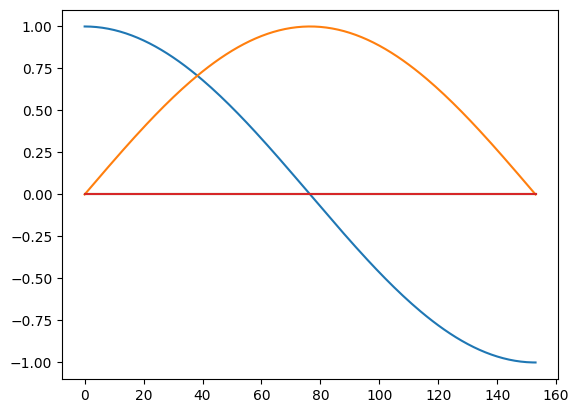

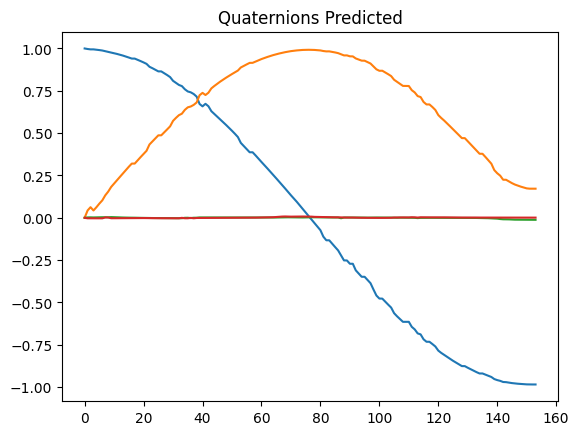

In [39]:
q1 = ig.quaternions.detach().cpu().numpy()
plt.plot(q1)
plt.show()
q2 = ov.quaternions.detach().cpu().numpy()
plt.plot(q2)
plt.title('Quaternions Predicted')
plt.show()


In [40]:
projs = ov.get_projections_np()

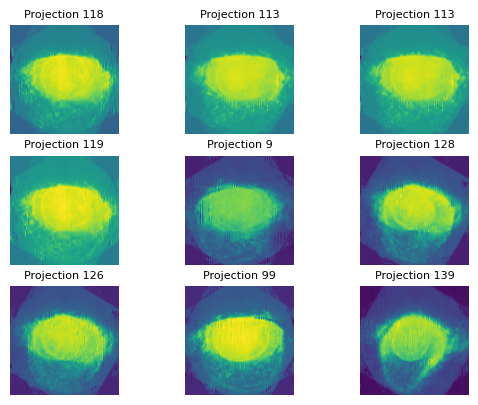

In [41]:
#Show some projections 3x3
fig, axs = plt.subplots(3, 3)
for i in range(9):
    ik = np.random.randint(0, projs.shape[0])
    axs[i//3, i%3].imshow(projs[ik])
    axs[i//3, i%3].set_title(f'Projection {ik}', fontsize=8)
    axs[i//3, i%3].axis('off')
plt.show()


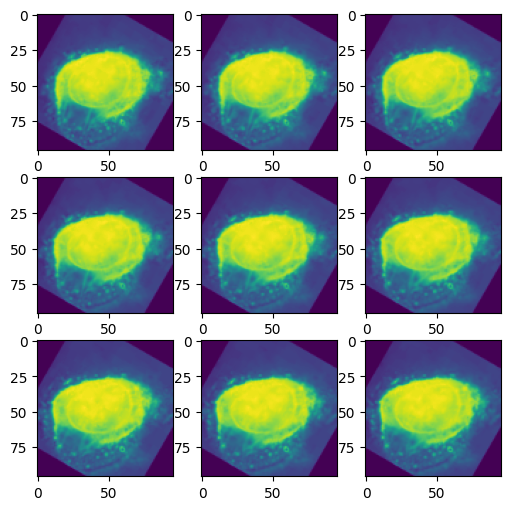

In [42]:
# Visualise 3x3 grid of projections
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(ig.frames.squeeze(1).cpu().numpy()[i*3+j])
plt.show()

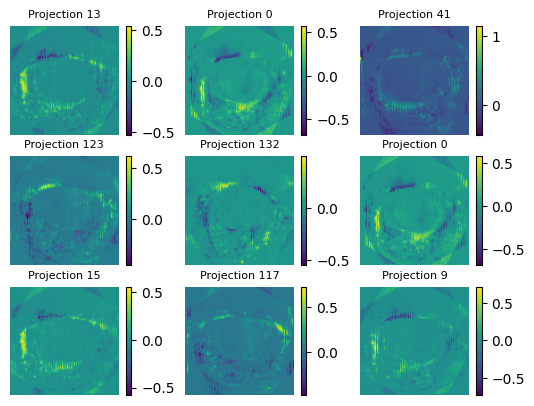

In [43]:
#Show projections vs. true projections
fig, axs = plt.subplots(3, 3)
for i in range(9):
    ik = np.random.randint(0, projs.shape[0])
    im = axs[i//3, i%3].imshow(ig.frames[ik,0].cpu().numpy() - projs[ik])
    axs[i//3, i%3].set_title(f'Projection {ik}', fontsize=8)
    axs[i//3, i%3].axis('off')
    fig.colorbar(im, ax=axs[i//3, i%3])
plt.show()
